In [1]:
import praw
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.preprocessing import StandardScaler
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report

# EDA

In [5]:
df = pd.read_csv('C:/Users/james/Documents/GA/Projects/project-3/Data/bigscrape.csv')
df.shape

(9661, 5)

In [6]:
df.head(3)

,created_utc,title,self_text,subreddit,utc_datetime
0,1.709157e+09,Should Racers shave their heads?,"During the 2023 Tour De France, several of the...",cycling,2024-02-28 21:20:22
1,1.709157e+09,Long distance ride advice,"Fellow humans,\n\nI am planning a long distanc...",cycling,2024-02-28 21:12:03
2,1.709155e+09,Need help picking a new bike,I'll be using the bike to go to and from work ...,cycling,2024-02-28 20:49:34


In [7]:
# identified samples with irelevant charachters such as "\n" e.g. that need to be removed
df.sample(5)

,created_utc,title,self_text,subreddit,utc_datetime
8102,1.706099e+09,Should I start Pilates at the start of my weig...,"Hi all,\n\nI hope you're all well!\n\nI just h...",pilates,2024-01-24 12:16:05
7706,1.598897e+09,Finally Got A Partner!,I’ve been road cycling for about 6 months off ...,cycling,2020-08-31 17:57:35
4285,1.705088e+09,Brazilian Butt Lifts?,Has anyone taught someone with Brazilian butt ...,pilates,2024-01-12 22:50:43
9639,1.707788e+09,Wattage on gym bikes vs actual road bikes,I've noticed this rather weird discrepancy bet...,cycling,2024-02-13 01:41:23
6149,1.708659e+09,Buy Assioma Duos Now Or Wait,I was debating buying some duos (or unos) but ...,cycling,2024-02-23 03:30:54


In [8]:
df.head(3)

,created_utc,title,self_text,subreddit,utc_datetime
0,1.709157e+09,Should Racers shave their heads?,"During the 2023 Tour De France, several of the...",cycling,2024-02-28 21:20:22
1,1.709157e+09,Long distance ride advice,"Fellow humans,\n\nI am planning a long distanc...",cycling,2024-02-28 21:12:03
2,1.709155e+09,Need help picking a new bike,I'll be using the bike to go to and from work ...,cycling,2024-02-28 20:49:34


FileNotFoundError: [Errno 2] No such file or directory: 'images/Distribution of subreddit posts.png'

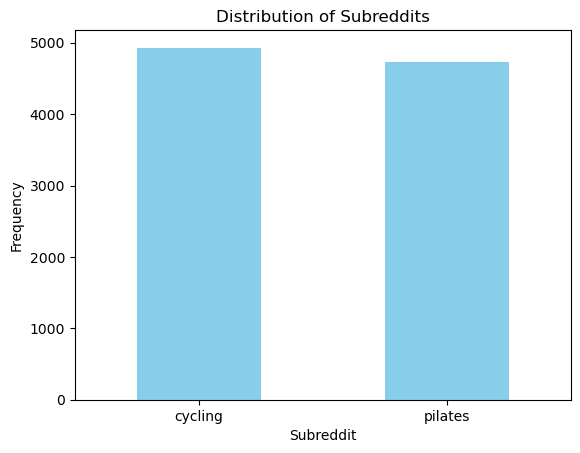

In [9]:
# plot the count of posts within each subreddit
subreddit_counts = df['subreddit'].value_counts()
subreddit_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Subreddit')
plt.ylabel('Frequency')
plt.title('Distribution of Subreddits')
plt.xticks(rotation=0);
# plt.savefig('images/Distribution of subreddit posts.png');

## Cleaning

In [ ]:
# drop duplicate text to avoid inaccurate data predictions
df = df.drop_duplicates()
df.shapez

In [ ]:
# created binaries out of subreddit column
df['subreddit'] = np.where(df['subreddit'] == 'cycling', 0, 1)

In [ ]:
# dropped unnecessary columns
df = df.drop(columns=['created_utc', 'utc_datetime', 'title'], axis=1)

In [ ]:
# check for class imbalance
df['subreddit'].value_counts().sort_index()

In [ ]:
# IMPUTED 508 out of 7717 NANs
df.dropna(subset=['self_text'], inplace=True)

In [ ]:
# Remove newline characters (\n) from text_column
df['self_text'] = df['self_text'].str.replace('\n', '')

In [ ]:
# confirm if any NANs in dataframe
df['self_text'].isna().sum()

In [ ]:
# confirm if any nulls in dataframe
df['self_text'].isna().sum()

In [ ]:
df.sample(2)

In [ ]:
# Save cleaned dataframe as CSV
# df.to_csv('data/cleaned_df.csv', index=False)

In [ ]:
# read in the clean csv for NLP
# df = pd.read_csv('data/cleaned_df.csv')

# Pre-Processing & NLP

In [10]:
X = df['self_text']
y = df['subreddit']
print(X.shape)
print(y.shape)

(9661,)
(9661,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
cvec = CountVectorizer(stop_words= 'english')
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
X_train_df = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names_out())

In [ ]:
cvec.get_feature_names_out()[5050:5100]

In [ ]:
# top occuring words with stop words removed
# NOTE: Top words are "bike" & "pilates"
X_train_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', color='skyblue');
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.title('Top 10 Most Occurring Words');
plt.savefig('images/mostoccurringwords.png')
# source: NLP II Lesson

In [13]:
X_train.shape, X_test.shape

((7245,), (2416,))

In [14]:
cvec = CountVectorizer(stop_words= 'english', ngram_range=(2, 2))
cvec.fit(X_train)
X_train_bigram_cvec = cvec.transform(X_train)
X_test_bigram_cvec = cvec.transform(X_test)
X_train_bigram_df = pd.DataFrame(X_train_bigram_cvec.todense(), columns=cvec.get_feature_names_out())

ValueError: np.nan is an invalid document, expected byte or unicode string.

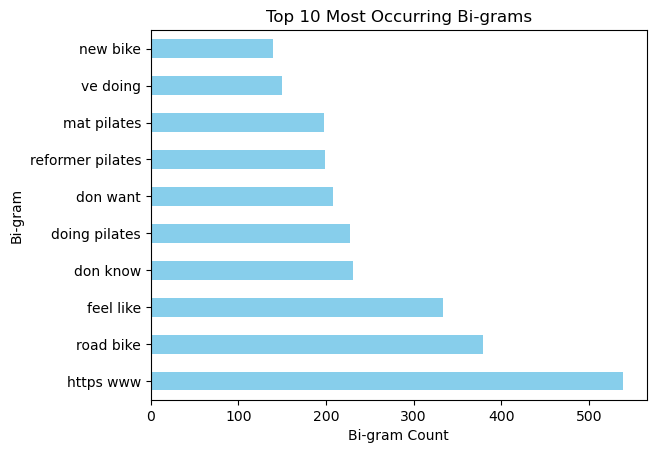

In [322]:
# top occuring words with stop words removed
X_train_bigram_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', color='skyblue');
plt.xlabel('Bi-gram Count')
plt.ylabel('Bi-gram')
plt.title('Top 10 Most Occurring Bi-grams');
plt.savefig('images/mostoccurringbigrams.png');
# source: NLP II Lesson

In [288]:
cvec.get_feature_names_out()[5000:5050]

array(['accident accident', 'accident aggressive', 'accident assuming',
       'accident bike', 'accident calling', 'accident came',
       'accident did', 'accident didn', 'accident does',
       'accident driver', 'accident dying', 'accident edge',
       'accident emergency', 'accident fact', 'accident happened',
       'accident help', 'accident highway', 'accident https',
       'accident injury', 'accident intermediate', 'accident involving',
       'accident july', 'accident kid', 'accident kinda',
       'accident occurring', 'accident overly', 'accident petition',
       'accident problem', 'accident reckless', 'accident resulting',
       'accident shortly', 'accident single', 'accident surgeries',
       'accident thing', 'accident try', 'accident vehicles',
       'accident waiting', 'accident wasn', 'accident wheelchair',
       'accidental defense', 'accidental pausing', 'accidentally buy',
       'accidentally hand', 'accidentally leave', 'accidentally miss',
       'acc

In [ ]:
'cvec__ngram_range': [(1, 1), (1, 2), (2, 2), (3, 3)

In [325]:
df.head(2)

,created_utc,title,self_text,subreddit,utc_datetime
0,1.709157e+09,Should Racers shave their heads?,"During the 2023 Tour De France, several of the...",cycling,2024-02-28 21:20:22
1,1.709157e+09,Long distance ride advice,"Fellow humans,\n\nI am planning a long distanc...",cycling,2024-02-28 21:12:03


In [195]:
#function to lemmatize each word in our dataframe
def lemmatize_post(post):
    # split into words
    split_post = post.split()
    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    # lemmatize and rejoin
    return " ".join([lemmatizer.lemmatize(word) for word in split_post])
# source cited: NLP II lesson

In [196]:
# test lemmatizer function
lemmatize_post('bike studies bikes pilate pilates weight weights the for an test rides biking')

'bike study bike pilate pilate weight weight the for an test ride biking'

In [197]:
# function to stem each word in our dataframe
def stem_post(post):
    # split into words
    split_post = post.split()
    #instantiate stemmer
    p_stemmer = PorterStemmer()
    # stem and rejoin
    return ' '.join([p_stemmer.stem(word) for word in split_post])
# source cited: NLP II lesson

In [198]:
# test stemming function
stem_post('bike studies bikes pilate pilates weight weights the for an test rides biking')

'bike studi bike pilat pilat weight weight the for an test ride bike'

# Baseline Accuracy and Summary Statistics

##### the baseline score here is the majority class ("pilates" subreddit posts). This simple baseline model will predict posts to be "pilates" 54.4% of the time.

In [199]:
1 - y_test.mean()
# 0 = cycling 
# 1 = pilates

0.5438401775804662

In [300]:
# balance of y values
df['subreddit'].value_counts()

subreddit
0    3818
1    3388
Name: count, dtype: int64

### How will success be evaluated?
##### Since we have balanced classes our accuracy score of each model will be the biggest determining factor. If we can get our model close to 99% this will be far better than the baseline model described above. The other primary factor is how much can we eliminate false positives with our model.

# Modeling

#### For this project we will be implementing Logistic Regression, Random Forests, and Naive Bayes Models.

## Naive Bayes Model - Parameter tuning via Gridsearching
#### Found a significant improvement in test score by increasing max_featuresto: 20,000 
#### These parameters also helped  improve the score slightly: cvec__min_df: 1, cvec_max_df: .85, 'cvec__ngram_range': [(1, 1)], and cvec__stop_words': None

In [203]:
X = df['self_text']
y = df['subreddit']
print(X.shape)
print(y.shape)

(7206,)
(7206,)


In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [205]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [206]:
# All parameters for Naive Bayes and Count Vectorizer
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True,
 'nb__force_alpha': 'warn'}

In [207]:
pipe_params = {
    'cvec__max_features': [20_000],
    'cvec__min_df': [1],
    'cvec__max_df': [.85],
    'cvec__ngram_range': [(1, 1)],
    'cvec__stop_words': [None, 'english'],
    'cvec__preprocessor' : [None, stem_post],
}

In [208]:
# stopwords for both subreddits
# print(CountVectorizer(stop_words = 'english').get_stop_words())

In [209]:
# Features explored during this gridsearch:
# 3_000, 4_000,
# 'cvec__max_features': [2_000, 3,000, 4,000, 5,000, 10_000, 12_000, 20_000, 25,000 30_000]
# 'cvec__min_df': [1, 2, 3, 4, 5]
# 'cvec__max_df': [.85, .9, .98],
# 'cvec__ngram_range': [(1, 1), (1, 2), (2, 2), (3, 3)
# 'cvec__stop_words': [None, 'english'],

##### • Score goes up as we increase "max_features"

In [210]:
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5,)

In [211]:
gs.fit(X_train, y_train)

C:\Users\james\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.85], 'cvec__max_features': [20000],
                         'cvec__min_df': [1], 'cvec__ngram_range': [(1, 1)],
                         'cvec__preprocessor': [None,
                                                <function stem_post at 0x0000027F5FF77F60>],
                         'cvec__stop_words': [None, 'english']})

In [212]:
gs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 20000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': <function __main__.stem_post(post)>,
 'cvec__stop_words': 'english'}

In [213]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9900074019245003, 0.9861265260821309)

## Logistic Regression and Count Vectorizer 

In [746]:
X = df['self_text']
y = df['subreddit']

In [748]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [749]:
# cvec = CountVectorizer() scores below without using stop words: 
# train score 0.999075
# test score 0.988352

In [750]:
# Test score improved with using stop words(english)
cvec = CountVectorizer(stop_words= 'english')
# train score 0.999075
# test score 0.991125

In [751]:
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [752]:
logreg = LogisticRegression(max_iter=10_000)

In [753]:
logreg.fit(X_train_cvec, y_train)
print(logreg.score(X_train_cvec, y_train))
print(logreg.score(X_test_cvec, y_test))

0.9990751017388088
0.9911259012756517


## Random Forests Model

In [227]:
X = df['self_text']
y = df['subreddit']

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [229]:
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [234]:
X_train_df = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names_out())
X_train_df.head(3)

,00,000,000ft,000lb,000m,000rmb,00am,00pm,015_revo,01hpwmbmasn561fv6nw34hmk0c,...,zones,zoom,zt8dxmptv,zumba,zumo,zurich,zw4,zwift,århus,ăn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [235]:
1 - y_train.mean()

0.5251665433012583

In [240]:
rf = RandomForestClassifier(oob_score=True, max_features='sqrt')
rf.fit(X_train_cvec, y_train)

RandomForestClassifier(oob_score=True)

In [242]:
rf.score(X_train_cvec, y_train), rf.score(X_test_cvec, y_test), rf.oob_score_

(1.0, 0.9905660377358491, 0.9901924500370096)

#### model is overfit with a train score of 1.0  and test score of .990192

# MODEL OF CHOICE
## Logistic Regression w/ GridSearch 

In [248]:
df.head(1)

,self_text,subreddit
0,"During the 2023 Tour De France, several of the...",0


In [249]:
X = df['self_text']
y = df['subreddit']
print(X.shape)
print(y.shape)

(7206,)
(7206,)


In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [251]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('log' , LogisticRegression(max_iter = 10_000))
])

In [252]:
# All parameters for Naive Bayes and Count Vectorizer
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()),
  ('log', LogisticRegression(max_iter=10000))],
 'verbose': False,
 'cvec': CountVectorizer(),
 'log': LogisticRegression(max_iter=10000),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'log__C': 1.0,
 'log__class_weight': None,
 'log__dual': False,
 'log__fit_intercept': True,
 'log__intercept_scaling': 1,
 'log__l1_ratio': None,
 'log__max_iter': 10000,
 'log__multi_class': 'auto',
 'log__n_jobs': None,
 'log__penalty': 'l2',
 'log__random_state': None,
 'log__solver': 'lbfgs',
 'log__tol': 0.0001,
 'lo

In [253]:
params = {
    'cvec__preprocessor' : [stem_post],
    'cvec__stop_words': [None, 'english']
}

### The lemmatizer was removed because the train scorewas  of 1.0 and it lowered the test score, it also consumed extra and uneccessary time to run the model with this function.

In [255]:
gs = GridSearchCV(pipe, params)
gs.fit(X_train, y_train)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))
print(gs.best_params_);
# train 0.999075
# test 0.993344

# 0.999444
# 0.992230

C:\Users\james\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

0.9994448556624722
0.9922308546059934
{'cvec__preprocessor': <function stem_post at 0x0000027F5FF77F60>, 'cvec__stop_words': 'english'}


In [256]:
gs.best_params_

{'cvec__preprocessor': <function __main__.stem_post(post)>,
 'cvec__stop_words': 'english'}

## Why was this model the best choice?
#### - This model provided the highest train and test score
#### - It was not underfit nor overfit as the model performed well on both the train and test score, yet both scores were very close together.
#### - Of all posts, it predicted 98.9% were actually from Cycling and 99.5% were actually from Pilates.

## Interpretation and Inference

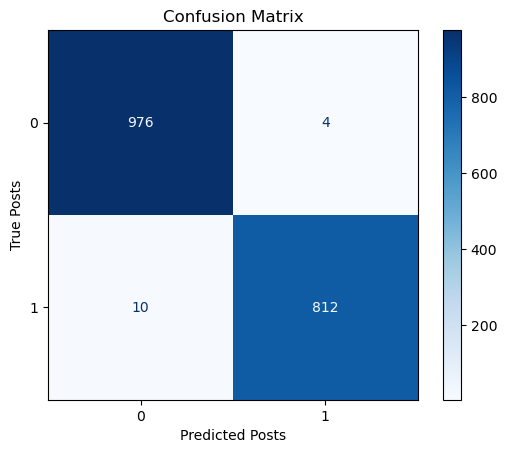

In [326]:
preds = gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Posts')
plt.ylabel('True Posts');
plt.savefig('images/confusionmatrix.png')

In [259]:
# 0 is Cycling, 1 is Pilates
print(classification_report(y_test, preds, digits = 5))

              precision    recall  f1-score   support

           0    0.98986   0.99592   0.99288       980
           1    0.99510   0.98783   0.99145       822

    accuracy                        0.99223      1802
   macro avg    0.99248   0.99188   0.99217      1802
weighted avg    0.99225   0.99223   0.99223      1802



### Of all posts, 98.9% were actually from Cycling and 99.5% were actually from Pilates.
### out of all the posts, the model predicted the outcome correct 99.2% of the time(Precision).

## Conclusion and Future Recomendations

#### To conclude, our model of choice proves to predict the subreddit the text came from 99.2% of the time (Specificity)

##### The model proves to eliminate false positives over 99% of the time, alternatively we can say the model might give a false positive 0.5% of the time.

##### with this model, we can apply it to any subreddit to make the same predictions.

##### my recommendation for future steps in this project would be to create a function that can combine all of these steps by taking in as many subreddits the user will give it and have it take it all the way to model predictions to further automate this process.